In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from scipy import optimize

# Logistic regression

## 1. Introduction

The hypotesis function for the logistic regression model is defined as:

$$ h_\theta(x) = g(\theta^T x)$$

where function $g$ is the sigmoid function defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$.

## 1.1. Cost function and gradient

The cost function for the logistic regression model is expressed as:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

The gradient or the derivative of the cost function wrt the parameters $\theta_{j}$ is defined as:
$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

## 1.2.  Regularized logistic regression: Cost function and gradient

To fit complex decision boundary, feature mapping is often needed. However, using higher order feature mapping often leads to overfitting. Therefore, regularization is necessary to avoid overfitting. 

The cost function for the regularized logistic regression model is expressed as:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

The gradient or the derivative of the cost function wrt the parameters $\theta_{j}$ is defined as:

$$ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$


## 1.3. Calculating optimal $\theta_{j}$

To calculate the optimal parameters for $\theta_{j}$ that minimizes the cost function $(J)$, we will use the ```scipy.optimize.minimize``` function. Note that gradient descent could also be used but ```scipy.optimize.minimize``` gives access to more advanced optimization solvers.

## 2. Implementation

We will be implementing the regularized logistic regression since setting $\lambda = 0$ recovers the unregularized logistic regression.


In [2]:
class LogisticRegression():
    def __init__(self, maxiter=100, learning_rate=0.001, lambda_=0.0, method='TNC'):
        self.learning_rate = learning_rate
        self.maxiter = maxiter
        self.history = list()
        self.weights = None
        self.lambda_ = lambda_
        self.method = method
        
    def _sigmoid(self, z):
        '''sigmoid funciton'''
        
        return 1./(1.+np.exp(-z))
    
    def _costFunction(self, weights, X, y):
        '''logistic regression cost function'''
        
        # number of training examples
        m = y.size
        
        # predictions
        pred = self._sigmoid(X.dot(weights))
        
        # cost function with regularization
        costFunc = 1./m*np.sum(-y*np.log(pred) - (1.-y)*np.log(1.-pred)) + \
                    (self.lambda_/(2.0*m))*np.sum(weights[1:]**2)
        
        # calculate gradients with regularization
        grad = 1./m * X.T.dot(pred-y) + (self.lambda_/m)*weights
        grad[0] = grad[0] - (self.lambda_/m)*weights[0]
        
        # cost function history
        self.history.append(costFunc)
        
        return costFunc, grad
    
    def _scipyOptimizer(self, X, y):
        '''uses scipy.optimize.minimize for calculating weights'''
        
        options= {'maxiter': self.maxiter}
        res = optimize.minimize(self._costFunction,
                                self.weights,
                                args=(X, y),
                                jac=True,
                                method='TNC',
                                options=options)
        
        # get results from scipy optimizer
        costFunc = res.fun
        self.weights = res.x
        return
    
    
    def _gradientDescent(self, X, y):
        '''gradient descent algorithm for calculating weights'''
        
        # number of training examples
        m = y.size
        
        # gradient descent iterations
        for i in range(self.maxiter):
            
            # evaluate cost function and gradients
            costFunc, grad = self._costFunction(self.weights, X, y)
            
            # update weights
            self.weights = self.weights - self.learning_rate/m * grad
        
        
    def fit(self, X, y):
        '''calculate weights'''
        
        # insert bias in first row
        X = np.insert(X, 0, 1, axis=1)
        
        # initialize weights
        self.weights = np.zeros(X.shape[1])
        
        # calculate optimized weights
        if self.method == 'gradientDescent':
            self._gradientDescent(X, y)
        else:
            self._scipyOptimizer(X, y)
                
            
    def predict(self, X):
        '''predict 0 or 1 class'''
        
        pred = self.predict_proba(X)
        pred[pred >= 0.5] = 1
        pred[pred < 0.5]  = 0
        return pred
        
    def predict_proba(self, X):
        '''predict probability'''
        
        # insert bias in first row
        X = np.insert(X, 0, 1, axis=1)
    
        return self._sigmoid(np.dot(X,self.weights))

# Helper functions

In [3]:
def mapFeature(X1, X2, degree):
    '''create higher order polynomial features specified degree'''
    
    result = []
    for i in range(1, degree + 1):
        for j in range(i + 1):
            result.append((X1 ** (i - j)) * (X2 ** j))
            
    return np.array(result).T

In [4]:
def plotData(X, y):
    '''Plot training dataset'''
    
    # define colormap
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    pos = (y==1)
    neg = (y==0)
    plt.plot(X[pos, 0], X[pos, 1], 'bo', ms=8, mec='k', mew=1)
    plt.plot(X[neg, 0], X[neg, 1], 'ro', ms=8, mec='k', mew=1)

In [5]:
def plot_decision_boundary(model, X, y, degree=0):
    '''plot the decision boundary of the model'''
    
    # domain mesh size
    h = 0.02
    # define domain
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # defince colormap
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    # Plot data
    plotData(X, y)
    
    # perform feature mapping if needed
    _X = np.c_[xx.ravel(), yy.ravel()]
    if degree >0:
        _X = mapFeature(_X[:, 0], _X[:, 1], degree)
    
    #Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = model.predict(_X)
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.4)

# Example 1: Unregularized logistic regression

This example will use the logistic regression model to predict whether a student gets admitted into a university. Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision. Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams.

## 1.1 Load and visualize the data

In [6]:
# Load data
# The first two columns contains the exam scores and the third column
# contains the label.
data = np.loadtxt(os.path.join('Data', 'ex2data1.txt'), delimiter=',')
X, y = data[:, 0:2], data[:, 2]

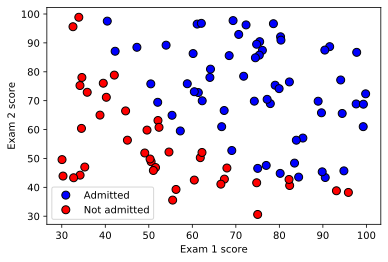

In [7]:
# Plot data
plotData(X, y)
# add axes labels
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Admitted', 'Not admitted'])
plt.show()

## 1.2 Define and fit model

In [8]:
model = LogisticRegression(maxiter=3000, lambda_=0.0, method='TNC')
model.fit(X, y)

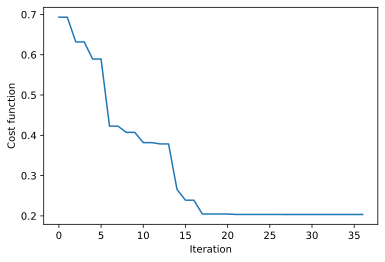

In [9]:
# Plot 'Iteration' vs 'Cost function'
plt.plot(model.history)
plt.xlabel('Iteration')
plt.ylabel('Cost function')
plt.show()

## 1.3 Plot model decision boundary

In [10]:
plot_decision_boundary(model, X, y)
# add axes labels
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Admitted', 'Not admitted'])
plt.show()

# Example 2: Regularized logistic regression

This example will use regularization in the logistic regression model to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

## 2.1 Load and visualize the data

In [11]:
# Load Data
# The first two columns contains the X values and the third column
# contains the label (y).
data = np.loadtxt(os.path.join('Data', 'ex2data2.txt'), delimiter=',')
X = data[:, :2]
y = data[:, 2]

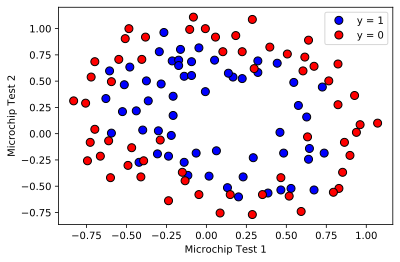

In [12]:
plotData(X, y)
# Labels and Legend
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0'], loc='upper right')

plt.show()

## 2.2 Feature mapping

One way to fit the data better is to create more features from each data point. The `mapFeature` defined in the helper functions section will map the features into all polynomial terms of $x_1$ and $x_2$ up to a given power/degree. We will use degree=6 (feel free to try other degrees).

$$ \text{mapFeature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T $$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. This example will use the regularized logistic regression by specifying the `lambda_` term in the argument. `lambda_ = 1` will be used in this example (feel free to try other values for `lambda_`).

In [13]:
# perform feature mapping
degree = 6
X = mapFeature(X[:, 0], X[:, 1], degree)

## 2.3 Define and fit model

In [14]:
lambda_ = 1.0
model = LogisticRegression(maxiter=3000, lambda_=lambda_, method='TNC')
model.fit(X, y)

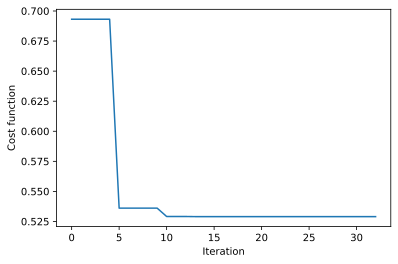

In [15]:
# Plot 'Iteration' vs 'Cost function'
plt.plot(model.history)
plt.xlabel('Iteration')
plt.ylabel('Cost function')
plt.show()

## 2.4 Plot model decision boundary

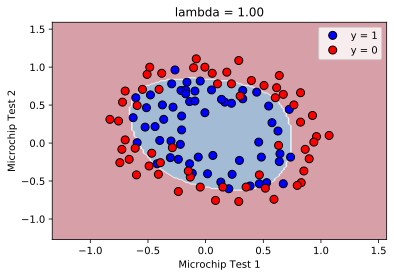

In [16]:
plot_decision_boundary(model, X, y, degree=degree)
# add axes labels
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(['y = 1', 'y = 0'])
plt.title('lambda = %0.2f' % lambda_)
plt.show()

In [17]:
# Compute accuracy on our training set
p = model.predict(X)

print('Train Accuracy: %.1f %%' % (np.mean(p == y) * 100))

Train Accuracy: 83.1 %


# Acknowledgements

Thanks to professor Andrew Ng for the awesome machine learning class on on Coursera.
All examples in this notebook were taken from the class.